In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F
from torchsummary import summary

from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, ConcatDataset

import os
import math
from IPython.display import clear_output

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

In [3]:
BATCH_SIZE=32
SEED=42
DEVICE = 'cuda'

## Посмотрим на данные 

In [6]:
df = pd.read_csv('train.csv')
print(df.head(10))

              T         X         Y         Z  Device
0  1.336645e+12  0.340509  8.308413  4.140585       7
1  1.336645e+12  0.381370  8.390134  4.249548       7
2  1.336645e+12  0.272407  8.471856  4.018002       7
3  1.336645e+12  0.149824  8.430995  4.290409       7
4  1.336645e+12  0.272407  8.430995  4.481094       7
5  1.336645e+12  0.422231  8.471856  4.712639       7
6  1.336645e+12  0.381370  8.390134  4.399372       7
7  1.336645e+12  0.313268  8.281172  4.399372       7
8  1.336645e+12  0.231546  8.308413  4.671778       7
9  1.336645e+12  0.231546  8.281172  4.562815       7


In [7]:
df = df.sort_values(by=['Device', 'T'], ascending=[True, True])

In [8]:
print(df.head(2))
print(df['T'][0], df['T'][1])

assert df['T'][0] < df['T'][1]

              T         X         Y         Z  Device
0  1.336645e+12  0.340509  8.308413  4.140585       7
1  1.336645e+12  0.381370  8.390134  4.249548       7
1336645068311.0 1336645068531.0


In [9]:
nunique_devices = df['Device'].nunique()
print('unique devices', nunique_devices)
print()

unique_devices = df['Device'].value_counts().sort_index()
print('devices id and count\n', unique_devices)
print()

print(f"Минимальная частота: {unique_devices.min()}")
print(f"Максимальная частота: {unique_devices.max()}")
print(f"Средняя частота: {unique_devices.mean()}")

unique devices 387

devices id and count
 7       523187
8       324429
9       149495
12       10468
23      353344
         ...  
1031      3271
1033    136455
1035     22111
1036     50638
1037    263110
Name: Device, Length: 387, dtype: int64

Минимальная частота: 3071
Максимальная частота: 1980574
Средняя частота: 76392.72093023256


In [10]:
df['T'] = pd.to_datetime(df['T'], unit='ms')

# Создать отдельные колонки для года, месяца, дня месяца, дня недели и часа
df['year'] = df['T'].dt.year
df['month'] = df['T'].dt.month
df['day'] = df['T'].dt.day
df['day_of_week'] = df['T'].dt.dayofweek  # Понедельник = 0, Воскресенье = 6
df['hour'] = df['T'].dt.hour

print(df.head())

                              T         X         Y         Z  Device  year  \
0 2012-05-10 10:17:48.311000064  0.340509  8.308413  4.140585       7  2012   
1 2012-05-10 10:17:48.531000064  0.381370  8.390134  4.249548       7  2012   
2 2012-05-10 10:17:48.753999872  0.272407  8.471856  4.018002       7  2012   
3 2012-05-10 10:17:48.971000064  0.149824  8.430995  4.290409       7  2012   
4 2012-05-10 10:17:49.191000064  0.272407  8.430995  4.481094       7  2012   

   month  day  day_of_week  hour  
0      5   10            3    10  
1      5   10            3    10  
2      5   10            3    10  
3      5   10            3    10  
4      5   10            3    10  


я решил не учитывать минуты тк размер входного вектора после one-hot encoding'а возрастет на 60  
И как мне кажется в жизни человека много хаотичности и минуты от дня ко дню могут отличаться  

Возможно есть смысл разбить час на четверти 

In [8]:
print(df['year'].min())
print(df['year'].max())

2012
2013


Я думаю колонку год можно убрать 

In [11]:
df = df.drop(['T', 'year'], axis=1)

In [10]:
print(df.head())
print(df.tail())

          X         Y         Z  Device  month  day  day_of_week  hour
0  0.340509  8.308413  4.140585       7      5   10            3    10
1  0.381370  8.390134  4.249548       7      5   10            3    10
2  0.272407  8.471856  4.018002       7      5   10            3    10
3  0.149824  8.430995  4.290409       7      5   10            3    10
4  0.272407  8.430995  4.481094       7      5   10            3    10
              X      Y      Z  Device  month  day  day_of_week  hour
29563978 -0.306 -0.306 -9.500    1037      5   13            6     6
29563979 -0.459 -0.306 -9.653    1037      5   13            6     6
29563980 -0.153 -0.306 -9.807    1037      5   13            6     6
29563981 -0.306 -0.459 -9.347    1037      5   13            6     6
29563982 -0.459 -0.766 -9.807    1037      5   13            6     6


Применим one-hot encoding к month, day, day_of_week, hour

In [12]:
columns_to_encode = ['month', 'day', 'day_of_week', 'hour']
df = pd.get_dummies(df, columns=columns_to_encode)

In [12]:
print(df.head(1))

          X         Y         Z  Device  month_3  month_5  month_6  month_7  \
0  0.340509  8.308413  4.140585       7        0        1        0        0   

   month_8  month_9  ...  hour_14  hour_15  hour_16  hour_17  hour_18  \
0        0        0  ...        0        0        0        0        0   

   hour_19  hour_20  hour_21  hour_22  hour_23  
0        0        0        0        0        0  

[1 rows x 74 columns]


In [13]:
print(df.columns)

Index(['X', 'Y', 'Z', 'Device', 'month_3', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23'],
      dtype='object')


### посмотрим на тестовые данные

In [14]:
df_test = pd.read_csv('test.csv')
print(df_test.head(10))

              T          X         Y         Z  SequenceId
0  1.364277e+12   8.662541  4.018002 -1.334794      100006
1  1.364277e+12  12.326415  5.202973 -1.688923      100006
2  1.364277e+12   8.090487  1.253072  0.544814      100006
3  1.364277e+12  10.923519 -0.858082 -1.021526      100006
4  1.364277e+12   7.763598 -0.108963 -1.171350      100006
5  1.364277e+12   7.763598 -0.068102 -3.473189      100006
6  1.364277e+12  18.346610  3.255263  2.547005      100006
7  1.364277e+12  12.353656  1.525479 -2.260978      100006
8  1.364277e+12   7.627395 -0.122583  0.340509      100006
9  1.364277e+12  10.787315 -1.171350  1.893228      100006


In [15]:
nunique_devices = df_test['SequenceId'].nunique()
print('unique devices', nunique_devices)
print()

unique_devices = df_test['SequenceId'].value_counts().sort_index()
print('devices id and count\n', unique_devices)
print()

print(f"Минимальная частота: {unique_devices.min()}")
print(f"Максимальная частота: {unique_devices.max()}")
print(f"Средняя частота: {unique_devices.mean()}")

unique devices 90024

devices id and count
 100006    300
100011    300
100012    300
100033    300
100044    300
         ... 
999968    300
999970    300
999974    300
999975    300
999998    300
Name: SequenceId, Length: 90024, dtype: int64

Минимальная частота: 300
Максимальная частота: 300
Средняя частота: 300.0


## Возвращаемся к пайплайну

Поскольку в тесте для каждого девайса есть только 300 записей, следовательно для обучения тоже берем 300

Получим все уникальные айдишники

In [13]:
devices_ids = df['Device'].unique()

In [14]:
target_column = 'Device'

train_records = {}
eval_records = {}

for id in devices_ids:
    filtered_df = df[df['Device'] == id]

    last_300_records = filtered_df.tail(300)
    other_records = filtered_df.iloc[:-300]

    train_records[id] = other_records.drop(target_column, axis=1)
    eval_records[id] = last_300_records.drop(target_column, axis=1)

In [15]:
len1 = len(df[df['Device'] == devices_ids[0]])
len2 = len(train_records[devices_ids[0]])
len3 = len(eval_records[devices_ids[0]])
print(len1)
print(len2)
print(len3)

assert len1 == len2 + len3 == 523187

523187
522887
300


In [17]:
print(eval_records[devices_ids[0]])

                X         Y             Z  month_3  month_5  month_6  month_7  \
522887  10.188020  2.111154 -3.813709e-01        0        0        0        1   
522888   8.921328  2.369940 -1.906856e-01        0        0        0        1   
522889   9.193735  1.920469 -3.234863e-07        0        0        0        1   
522890   9.997335  2.179256 -1.089633e-01        0        0        0        1   
522891   9.234595  2.342700 -2.996486e-01        0        0        0        1   
...           ...       ...           ...      ...      ...      ...      ...   
523182   9.615966  2.451662 -6.129172e-01        0        0        0        1   
523183   9.956474  1.920469  2.315461e-01        0        0        0        1   
523184  10.119919  1.184970  5.311925e-01        0        0        0        1   
523185   8.471856  1.566340  3.813683e-01        0        0        0        1   
523186  10.569390  1.266692  9.534242e-01        0        0        0        1   

        month_8  month_9  m

<> Попробуем сначале без нормализации

## Pytorch time

Обертка для датасета, который будет применен для каждого id отдельно. Но служит для того, что бы обеспечить выдачу Х определенного размера=300 (объединяя несколько записей в один сэмпл) 

In [16]:
id2norm = {} # каждому номеру сопоставим порядковый номер который потом за энкодим
for i, d_id in enumerate(devices_ids):
    id2norm[d_id] = i
print(len(id2norm))

387


In [17]:
class ID_DS(Dataset):
    def __init__(self, data, device_id, window_size = 50, bs=300):
        if window_size > bs:
            print('You missing samples if window_size > bs')

        self.device_id = device_id
        self.data=data
        self.bs = bs
        
        self.window_size = window_size
    def __len__(self):
        return (len(self.data) - self.bs) // self.window_size + 1
    
    def __getitem__(self, idx):
        return self.data[idx*self.window_size
                         : idx*self.window_size+self.bs] , id2norm[self.device_id]
    

In [20]:

def test_id_ds(silent_mode=False):
    d_id = 7
    data1 = [1, 2, 3, 4, 5]
    answers = [
    [[1], [2], [3], [4], [5]],
    [[1], [3], [5]],
    [[1, 2], [2, 3], [3, 4], [4, 5]],
    [[1, 2], [3, 4]]
    ]
    ws_s = [1, 2, 1, 2]
    bs_s = [1, 1, 2, 2]

    for i, (answ, ws, bs) in enumerate(zip(answers, ws_s, bs_s)):
        if not silent_mode:
            print('test', i+1)

        ds_out = []
        ds1 = ID_DS(data1, d_id, window_size=ws, bs=bs)

        for i in range(len(ds1)):
            if not silent_mode:
                print(ds1[i])
            ds_out.append(ds1[i])

        assert ds_out == [(local_answer, id2norm[d_id]) for local_answer in answ]
    
    if not silent_mode:
        print('All tests passed')

test_id_ds(silent_mode=True)




You missing samples if window_size > bs


переведем из пандаса в торч

In [21]:

for device_id in train_records.keys():
    train_records[device_id] = torch.tensor(train_records[device_id].to_numpy(), dtype=torch.float32)

for device_id in eval_records.keys():
    eval_records[device_id] = torch.tensor(eval_records[device_id].to_numpy(), dtype=torch.float32)

In [22]:
print(train_records[devices_ids[0]].shape)
#must be torch.Size([522887, 73])

torch.Size([522887, 73])


In [23]:
train_datasets = []
eval_datasets = []

for device_id in train_records.keys():
    train_datasets.append(ID_DS(data=train_records[device_id], device_id=device_id))

for device_id in eval_records.keys():
    eval_datasets.append(ID_DS(data=eval_records[device_id], device_id=device_id))


In [24]:
print(train_datasets[0].data)
print(train_datasets[0].device_id)

tensor([[ 0.3405,  8.3084,  4.1406,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3814,  8.3901,  4.2495,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2724,  8.4719,  4.0180,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.3027,  1.4982,  0.5040,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.4253,  1.3076,  0.3133,  ...,  0.0000,  0.0000,  0.0000],
        [ 8.0769,  2.4925, -0.0409,  ...,  0.0000,  0.0000,  0.0000]])
7


In [25]:
all_train_datasets = ConcatDataset(train_datasets)
all_eval_datasets = ConcatDataset(eval_datasets)

train_dl = DataLoader(all_train_datasets, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = DataLoader(all_eval_datasets, batch_size=BATCH_SIZE, shuffle=True)

## Model 

In [26]:
def plot_data(data, title='График данных',):
   
    plt.plot(data)
    plt.title(title)

    plt.grid(True)
    plt.show()

In [27]:
def batch_to_one_hot(batch, num_classes=None):
    num_classes = len(id2norm)

    one_hot_batch = torch.zeros((len(batch), num_classes))#, dtype=torch.long)
    one_hot_batch.scatter_(1, batch.unsqueeze(1), 1)

    return one_hot_batch

In [27]:
def test_one_hot_batch():
    for i, (x, y) in enumerate(train_dl):
        if i > 3:
            break

        print('Before "batch_to_one_hot"', y.shape)
        print('After "batch_to_one_hot"', batch_to_one_hot(y).shape)
        

test_one_hot_batch()

Before "batch_to_one_hot" torch.Size([4])
After "batch_to_one_hot" torch.Size([4, 387])
Before "batch_to_one_hot" torch.Size([4])
After "batch_to_one_hot" torch.Size([4, 387])
Before "batch_to_one_hot" torch.Size([4])
After "batch_to_one_hot" torch.Size([4, 387])
Before "batch_to_one_hot" torch.Size([4])
After "batch_to_one_hot" torch.Size([4, 387])


In [28]:
def eval_epoch(model, eval_loader, criterion):
    model.eval()
    #val_acc = 0
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(eval_loader):
        inputs = inputs.to(DEVICE)
        y_true_num = labels.to(DEVICE)
        labels = batch_to_one_hot(labels).to(DEVICE)
        labels = labels.to(DEVICE)
        #print('inputs', inputs.shape)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)


        running_loss += loss.item() * inputs.size(0)
        #score = roc_auc_score(labels.to('cpu'), preds.to('cpu'))
        running_corrects += torch.sum(preds == y_true_num)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc#, score

In [29]:
def eval_wrongs(model, eval_loader):
    model.eval()
    true_preds = []
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(eval_loader):
        inputs = inputs.to(DEVICE)
        y_true_num = labels.to(DEVICE)
        labels = batch_to_one_hot(labels).to(DEVICE)
        labels = labels.to(DEVICE)
        #print('inputs', inputs.shape)
        with torch.no_grad():
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)

        true_preds.append((preds, y_true_num))
        #running_corrects += torch.sum(preds == y_true_num)
        #processed_size += inputs.size(0)

    #val_acc = running_corrects.double() / processed_size
    return true_preds#val_acc#, score

In [170]:
def test_eval_epoch():
    model = LSTM_LM(input_dim=73, hidden_dim=128, vocab_size=len(id2norm))#nn.LSTM(73, len(id2norm), batch_first=True) #nn.Linear(73, len(id2norm))
    
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    val_loss, val_acc = eval_epoch(model, eval_dl, criterion)
    print(f'avg loss: {val_loss}')
    print(f'avg accur: {val_acc}')

test_eval_epoch()

  0%|          | 0/97 [00:00<?, ?it/s]

avg loss: 5.967334704189645
avg accur: 0.002583979328165375


In [30]:
class sheduler_placeholder:
    def step(self):
        pass

In [78]:
def train_model(model, optimizer, criterion,train_dataloader, eval_dataloader, num_epoch=25, sheduler = sheduler_placeholder(), save_best=False, save_path='modelname.pth'):
    history = []
    corrects = []
    losses = []
    running_corrects = 0
    processed_size = 0
    eval_loss = eval_ac = 0
    best_eval_acc = 0

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, (inputs, labels) in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:', leave=False)):
            inputs = inputs.to(DEVICE)
            y_true_num = labels.to(DEVICE)
            labels = batch_to_one_hot(labels).to(DEVICE)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

            loss.backward()
            optimizer.step()
            
            #sheduler.step()

            running_corrects += torch.sum(preds == y_true_num)
            processed_size += inputs.size(0)

            epoch_losses.append(loss.item())

            # print section
            if i % 5_00 == 0:
                eval_loss, eval_ac = eval_epoch(model, eval_dataloader, criterion)
                model.train()
                history.append((eval_loss, eval_ac))
                
                if save_best and (eval_ac > best_eval_acc):
                    best_eval_acc = eval_ac
                    torch.save(model.state_dict(), save_path)

            if i % 100 == 0:
                clear_output(wait=True)
                print(f'epo {epoch}/{num_epoch}')
                print('')
                print('current loss', float(loss))
                print('avg corrects', float(running_corrects.double() / processed_size))
                
                print('-'*20)
                print('eval loss', float(eval_loss))
                print('eval acc', float(eval_ac))
                print('best eval acc', float(best_eval_acc))
                print('#'*20)
        

                model.train()
        sheduler.step()
        losses.append(sum(epoch_losses) / len(epoch_losses))
        corrects.append(running_corrects.double() / processed_size)
        print('evaluating results:')
        history.append(eval_epoch(model, eval_dataloader, criterion))
        
    return losses, history

In [28]:
vocab_size = len(devices_ids)

начну с модели основаной на LSTM (или GRU если LSTM не влезет)

In [4]:
class MaxAggrigation(nn.Module):
    def forward(self, x):
        return x.max(dim=1)[0]

class MeanAggrigation(nn.Module):
    def forward(seld, x):
        return x.mean(dim=1)

class LSTM_LM(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, vocab_size: int, recurent_layers=1, aggregation_type: str = 'max', dropout=0.3):
        super().__init__()
        #input_dim - num of features in input (~73)
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=recurent_layers) 
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)

        if aggregation_type == 'max':
            self.aggregation = MaxAggrigation()
        elif aggregation_type == 'mean':
            self.aggregation = MeanAggrigation()

    def forward(self, input_batch) -> torch.Tensor:
        '''
        [batch_size, seq_len, hidden_dim]
        [batch_size, hidden_dim]
        [hidden_dim, hidden_dim]
        [batch_size, hidden_dim]
        '''
        output, _ = self.rnn(input_batch)
        output = self.aggregation(output)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

In [18]:
model = LSTM_LM(input_dim=73, hidden_dim=256, vocab_size=len(id2norm), dropout=0.4)
model.to(DEVICE)

LSTM_LM(
  (rnn): LSTM(73, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=387, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.4, inplace=False)
  (aggregation): MaxAggrigation()
)

In [22]:
total_params = sum(
	param.numel() for param in model.parameters()
)
print(total_params)

504195


In [35]:

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

losses, history = train_model(model=model,
                              optimizer=optimizer,
                              criterion=criterion,
                              train_dataloader=train_dl,
                              eval_dataloader=eval_dl,
                              num_epoch=40)

eval_loss, eval_ac = eval_epoch(model, eval_dl, criterion)
print('-'*20)
print('final eval')
print('eval loss', float(eval_loss))
print('eval acc', float(eval_ac))



Training epoch 39:: 100%|█████████▉| 18305/18339 [06:09<00:00, 49.75it/s]

epo 39/40

current loss 0.004806254990398884
avg corrects 0.933563774110041
--------------------
eval loss 2.680318821885789
eval acc 0.6821705426356589
####################


evaluating results:


100%|██████████| 13/13 [00:00<00:00, 112.50it/s]

--------------------
final eval
eval loss 2.8803943269320547
eval acc 0.6666666666666667


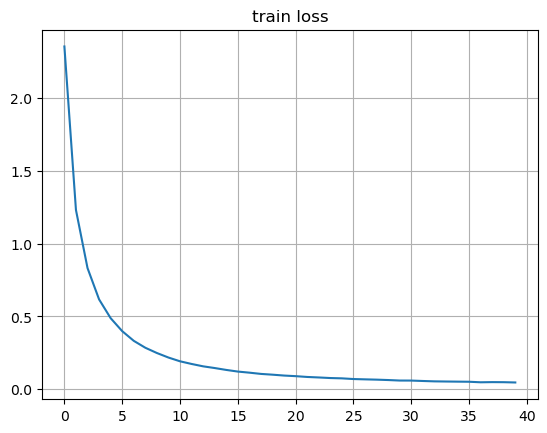

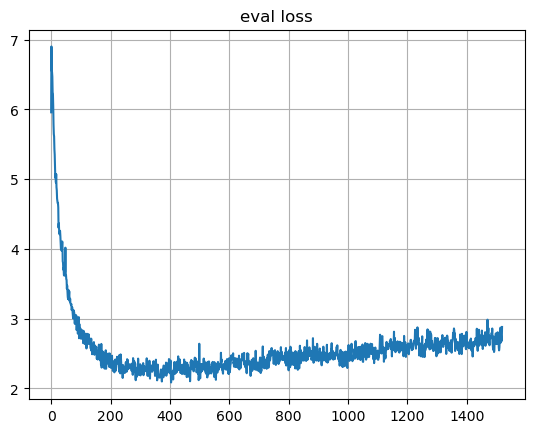

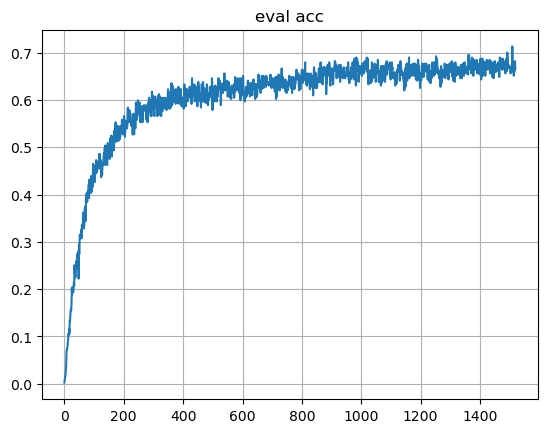

In [37]:
#losses, history(val_loss, val_acc) per epo
eval_losses = [item[0] for item in history]
eval_acc = [float(item[1]) for item in history]

for name, data in zip(['train loss', 'eval loss', 'eval acc'], [losses, eval_losses, eval_acc]):
    plot_data(data, title=name)

Training epoch 9:: 100%|█████████▉| 18307/18339 [05:59<00:00, 52.09it/s]

epo 9/10

current loss 0.15754227340221405
avg corrects 0.8059703476777142
--------------------
eval loss 2.3178024858775372
eval acc 0.5736434108527132
####################


evaluating results:


100%|██████████| 13/13 [00:00<00:00, 105.67it/s]


--------------------
final eval
eval loss 2.228047882247649
eval acc 0.6020671834625323


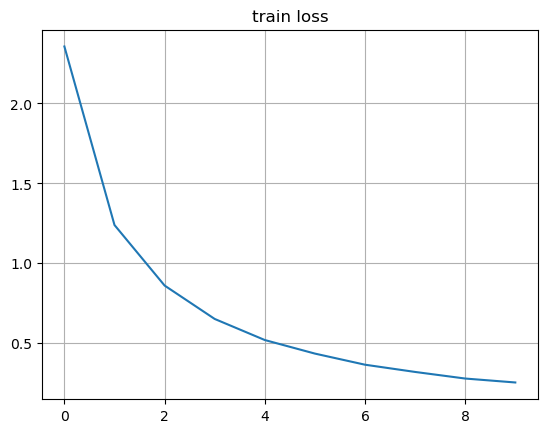

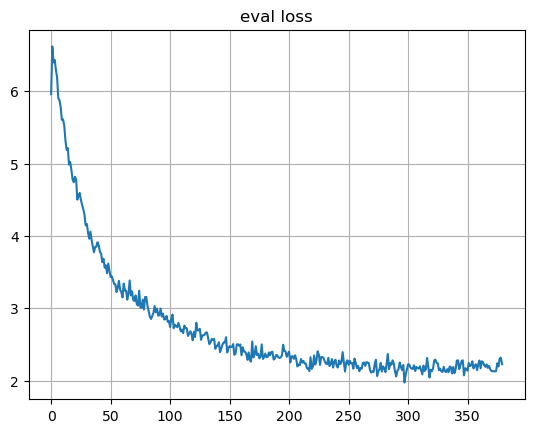

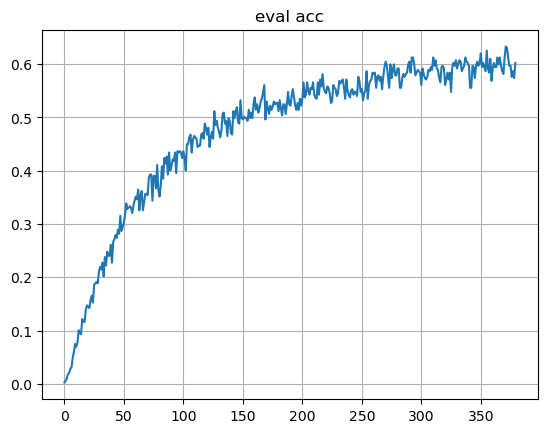

In [31]:

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

losses, history = train_model(model=model,
                              optimizer=optimizer,
                              criterion=criterion,
                              train_dataloader=train_dl,
                              eval_dataloader=eval_dl,
                              num_epoch=10)

eval_loss, eval_ac = eval_epoch(model, eval_dl, criterion)
print('-'*20)
print('final eval')
print('eval loss', float(eval_loss))
print('eval acc', float(eval_ac))

#losses, history(val_loss, val_acc) per epo
eval_losses = [item[0] for item in history]
eval_acc = [float(item[1]) for item in history]

for name, data in zip(['train loss', 'eval loss', 'eval acc'], [losses, eval_losses, eval_acc]):
    plot_data(data, title=name)

In [30]:
path = 'LSTM_066_b32_lr3e4_e40.pth'

torch.save(model.state_dict(), path)

In [80]:

path = 'LSTM_066_b32_lr3e4_e40.pth'
model = LSTM_LM(input_dim=73, hidden_dim=256, vocab_size=len(id2norm))

model.load_state_dict(torch.load(path))

<All keys matched successfully>

70% - текущий предел 

добавим слоев

In [38]:
model = LSTM_LM(input_dim=73, hidden_dim=256, vocab_size=len(id2norm), recurent_layers=2)
model.to(DEVICE)

LSTM_LM(
  (rnn): LSTM(73, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=387, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
  (aggregation): MaxAggrigation()
)

Training epoch 9:: 100%|█████████▉| 18306/18339 [10:34<00:01, 29.39it/s]

epo 9/10

current loss 0.1263587772846222
avg corrects 0.824117553917768
--------------------
eval loss 2.2940221338109317
eval acc 0.6563307493540051
####################


evaluating results:


100%|██████████| 13/13 [00:00<00:00, 64.03it/s]


--------------------
final eval
eval loss 2.1100522171927363
eval acc 0.6485788113695091


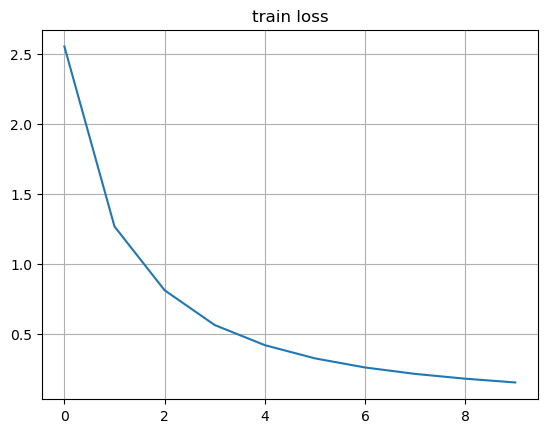

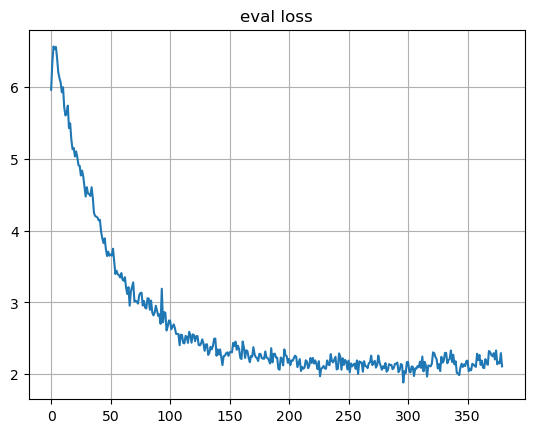

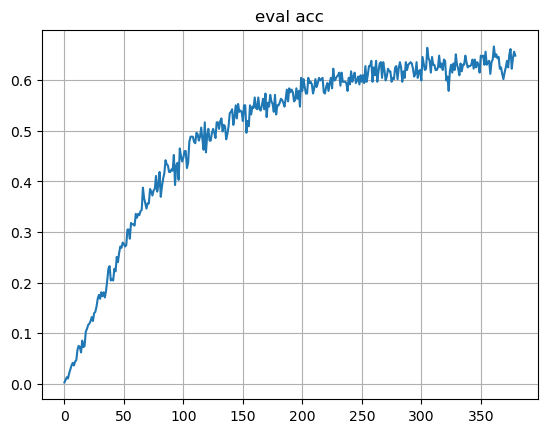

In [39]:

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

losses, history = train_model(model=model,
                              optimizer=optimizer,
                              criterion=criterion,
                              train_dataloader=train_dl,
                              eval_dataloader=eval_dl,
                              num_epoch=10)

eval_loss, eval_ac = eval_epoch(model, eval_dl, criterion)
print('-'*20)
print('final eval')
print('eval loss', float(eval_loss))
print('eval acc', float(eval_ac))

#########
#losses, history(val_loss, val_acc) per epo
eval_losses = [item[0] for item in history]
eval_acc = [float(item[1]) for item in history]

for name, data in zip(['train loss', 'eval loss', 'eval acc'], [losses, eval_losses, eval_acc]):
    plot_data(data, title=name)

ситуация не сильно изменилась, можно попробовать поработать с на моделью 

In [64]:

class LSTM_LM(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, vocab_size: int, recurent_layers=1):
        super().__init__()
        #input_dim - num of features in input (~73)
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=recurent_layers) 
        '''self.flat = nn.Flatten()


        self.linear = nn.Linear(300*hidden_dim, hidden_dim)

        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)'''

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Tanh(),
            #nn.BatchNorm1d(300*hidden_dim),
            nn.Linear(300*hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(p=0.3), 
            #nn.Tanh(),
            nn.ReLU(),
            nn.Linear(hidden_dim, vocab_size) 
            
        )


    def forward(self, input_batch) -> torch.Tensor:
        '''
        [batch_size, seq_len, hidden_dim]
        [batch_size, hidden_dim]
        [hidden_dim, hidden_dim]
        [batch_size, hidden_dim]
        '''
        output, _ = self.rnn(input_batch)
        projection = self.fc(output)
        '''output = self.flat(output)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))'''

        return projection

In [65]:
model = LSTM_LM(input_dim=73, hidden_dim=256, vocab_size=len(id2norm), recurent_layers=3)
model.to(DEVICE)

LSTM_LM(
  (rnn): LSTM(73, 256, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Tanh()
    (2): Linear(in_features=76800, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=387, bias=True)
  )
)

In [ ]:

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

losses, history = train_model(model=model,
                              optimizer=optimizer,
                              criterion=criterion,
                              train_dataloader=train_dl,
                              eval_dataloader=eval_dl,
                              num_epoch=5)

eval_loss, eval_ac = eval_epoch(model, eval_dl, criterion)
print('-'*20)
print('final eval')
print('eval loss', float(eval_loss))
print('eval acc', float(eval_ac))

#########
#losses, history(val_loss, val_acc) per epo
eval_losses = [item[0] for item in history]
eval_acc = [float(item[1]) for item in history]

for name, data in zip(['train loss', 'eval loss', 'eval acc'], [losses, eval_losses, eval_acc]):
    plot_data(data, title=name)

## Теперь свертки 

In [23]:
class ConvNormBlock(nn.Module):
    def __init__(self, out_channels, **conv_args):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(out_channels=out_channels, **conv_args),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.model(x)


class ConvM(nn.Module):
    def __init__(self, vocab_size, input_dim=73, row_stride = 2, conv_rows = 10):
        super().__init__()
        
        ks = (conv_rows,input_dim)

        self.model = nn.Sequential(
            ConvNormBlock(in_channels=1, out_channels=512, kernel_size=ks, stride=(row_stride, 1)),
            ConvNormBlock(in_channels=512, out_channels=1024, kernel_size=(conv_rows, 1), stride=(row_stride, 1)),
            ConvNormBlock(in_channels=1024, out_channels=2048, kernel_size=(conv_rows, 1), stride=(row_stride, 1)),
            #
            ConvNormBlock(in_channels=2048, out_channels=2048, kernel_size=(3, 1), padding=(1, 0)),
            #
            ConvNormBlock(in_channels=2048, out_channels=512, kernel_size=(conv_rows, 1), stride=(row_stride, 1)),

            ConvNormBlock(in_channels=512, out_channels=128, kernel_size=(3, 1), padding=(1, 0)),
            #

            nn.Flatten(),
            nn.Linear(128*11, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, vocab_size),
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        #print('x_shape', x.shape)
        x = self.model(x)
        #print('out_shape', x.shape)
        return x

In [24]:
model = ConvM(vocab_size=len(id2norm))
model.to(DEVICE)

ConvM(
  (model): Sequential(
    (0): ConvNormBlock(
      (model): Sequential(
        (0): Conv2d(1, 512, kernel_size=(10, 73), stride=(2, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvNormBlock(
      (model): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(10, 1), stride=(2, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvNormBlock(
      (model): Sequential(
        (0): Conv2d(1024, 2048, kernel_size=(10, 1), stride=(2, 1))
        (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvNormBlock(
      (model): Sequential(
        (0): Conv2d(2048, 2048, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affin

In [25]:
total_params = sum(
	param.numel() for param in model.parameters()
)
print(total_params)

50792195


In [31]:
test_in = torch.randn(32, 300, 73).to(DEVICE)
model(test_in)
None

Training epoch 4:: 100%|█████████▉| 18302/18339 [45:56<00:05,  6.58it/s]

epo 4/5

current loss 0.6140575408935547
avg corrects 0.7002506679250069
--------------------
eval loss 2.9281697150040658
eval acc 0.5322997416020672
####################


evaluating results:


100%|██████████| 13/13 [00:00<00:00, 40.49it/s]


--------------------
final eval
eval loss 2.796213803365249
eval acc 0.5297157622739018


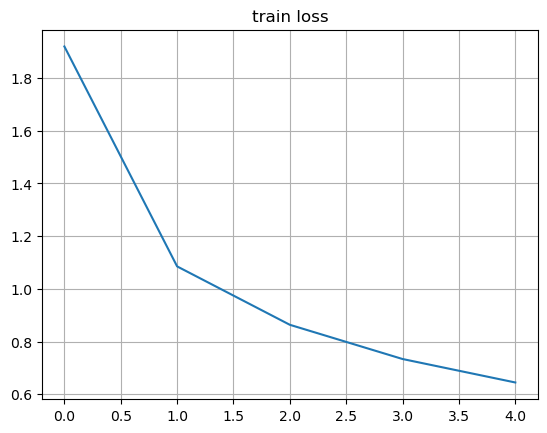

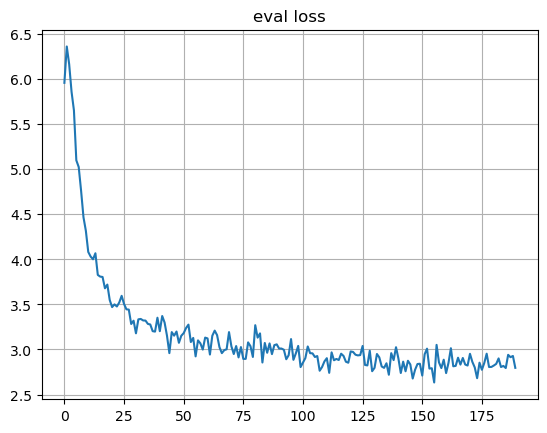

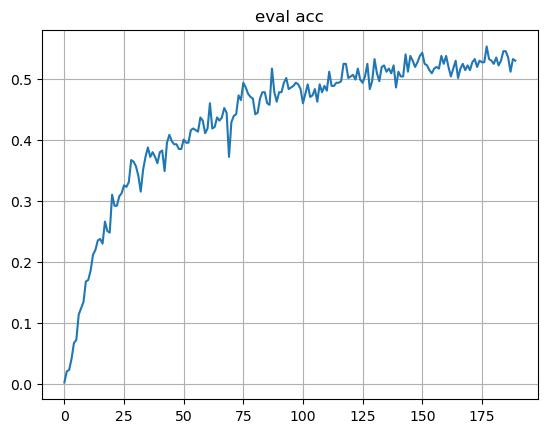

In [32]:

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

losses, history = train_model(model=model,
                              optimizer=optimizer,
                              criterion=criterion,
                              train_dataloader=train_dl,
                              eval_dataloader=eval_dl,
                              num_epoch=5)

eval_loss, eval_ac = eval_epoch(model, eval_dl, criterion)
print('-'*20)
print('final eval')
print('eval loss', float(eval_loss))
print('eval acc', float(eval_ac))

#########
#losses, history(val_loss, val_acc) per epo
eval_losses = [item[0] for item in history]
eval_acc = [float(item[1]) for item in history]

for name, data in zip(['train loss', 'eval loss', 'eval acc'], [losses, eval_losses, eval_acc]):
    plot_data(data, title=name)

## Трансформер

In [30]:
print(vocab_size)

387


In [26]:
class MyTransformer(nn.Module):
    def __init__(self, embedding_size, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()

        self.transformer = nn.Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout
        )

        self.fc = nn.Sequential(
            nn.Linear(embedding_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        # Зачем - а вот потаму что 'embed_dim must be divisible by num_heads'
        bs, seq_len, voc_s = x.shape
        zeros_tensor = torch.zeros(bs, seq_len, 2).to(DEVICE)
        #print('xs', x.shape)
        #print('zs', zeros_tensor.shape)
        x = torch.cat([x, zeros_tensor], dim=2)
        
        x = self.transformer(x, x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)

        return x



In [36]:
print(vocab_size)

387


In [29]:

num_heads = 15
num_layers = 4

embedding_size = 75
num_classes = vocab_size


model = MyTransformer(embedding_size, num_heads, num_layers, num_classes).to(DEVICE)

In [30]:
total_params = sum(
	param.numel() for param in model.parameters()
)
print(total_params)

2989951


In [ ]:
input_sequence = torch.randn(32, 300, 73)

output = model(input_sequence)
print(output.shape)

In [45]:

warmup_steps = 2
total_epochs = 7

# Планировщик скорости обучения с подогревом
def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    return max(0.0, 0.5 * (1.0 + math.cos((step - warmup_steps) / float(max(1, (total_epochs+1) - warmup_steps)) * math.pi)))

Training epoch 6:: 100%|█████████▉| 18302/18339 [41:01<00:04,  7.52it/s]

epo 6/7

current loss 0.025402262806892395
avg corrects 0.7756354967455066
--------------------
eval loss 44.484075487122055
eval acc 0.11627906976744186
####################


evaluating results:


100%|██████████| 13/13 [00:00<00:00, 23.25it/s]


--------------------
final eval
eval loss 39.049631212416855
eval acc 0.16020671834625325


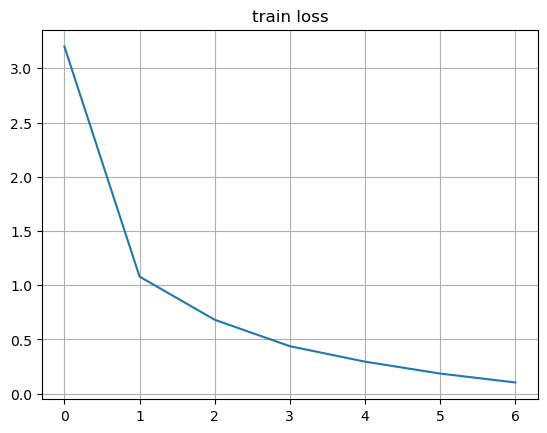

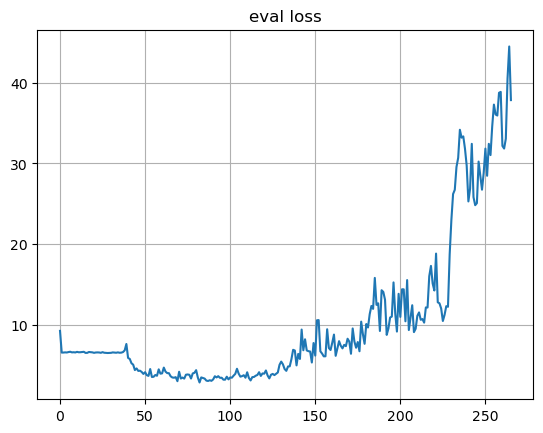

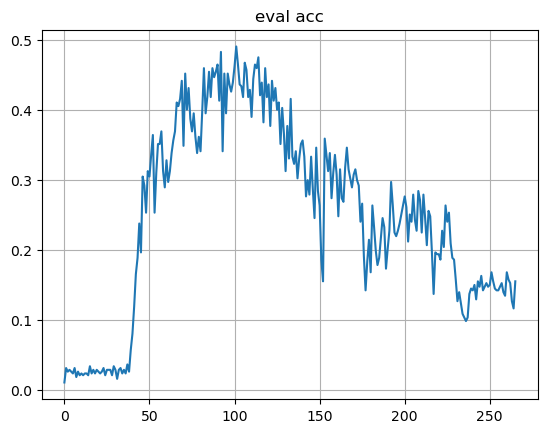

In [46]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = LambdaLR(optimizer, lr_lambda)

criterion = nn.CrossEntropyLoss()

losses, history = train_model(model=model,
                              optimizer=optimizer,
                              criterion=criterion,
                              train_dataloader=train_dl,
                              eval_dataloader=eval_dl,
                              num_epoch=total_epochs,
                              sheduler=scheduler,
                              save_best=True, save_path='trans_head15_lay4_do0_lr3e4.pth')

eval_loss, eval_ac = eval_epoch(model, eval_dl, criterion)
print('-'*20)
print('final eval')
print('eval loss', float(eval_loss))
print('eval acc', float(eval_ac))

#########
#losses, history(val_loss, val_acc) per epo
eval_losses = [item[0] for item in history]
eval_acc = [float(item[1]) for item in history]

for name, data in zip(['train loss', 'eval loss', 'eval acc'], [losses, eval_losses, eval_acc]):
    plot_data(data, title=name)

Больше без вармапов, но можно сделать вывод, что lr
0.001  
0.0009330127018922195 и возможно даже  
0.00075  
подходят хорошо

In [80]:

num_heads = 15
num_layers = 3

embedding_size = 75
num_classes = vocab_size


model = MyTransformer(embedding_size, num_heads, num_layers, num_classes, dropout=0).to(DEVICE)

In [81]:

path = 'trans_loaded_to4_2epo.pth'
#trans_loaded_to3epo - 67
#trans_loaded_to4epo - 68
# trans_loaded_to4_2epo - 69

model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [82]:

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-9)


criterion = nn.CrossEntropyLoss()

losses, history = train_model(model=model,
                              optimizer=optimizer,
                              criterion=criterion,
                              train_dataloader=train_dl,
                              eval_dataloader=eval_dl,
                              num_epoch=1,
                              save_best=True, save_path='trans_loaded_to4_2epo.pth')

eval_loss, eval_ac = eval_epoch(model, eval_dl, criterion)
print('-'*20)
print('final eval')
print('eval loss', float(eval_loss))
print('eval acc', float(eval_ac))

#########
#losses, history(val_loss, val_acc) per epo
eval_losses = [item[0] for item in history]
eval_acc = [float(item[1]) for item in history]

for name, data in zip(['train loss', 'eval loss', 'eval acc'], [losses, eval_losses, eval_acc]):
    plot_data(data, title=name)

Training epoch 0::   6%|▌         | 1102/18339 [01:57<30:25,  9.44it/s]

epo 0/1

current loss 0.18349100649356842
avg corrects 0.9548138056312443
--------------------
eval loss 1.8556883624665805
eval acc 0.661498708010336
best eval acc 0.6847545219638244
####################


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Bogdan\AppData\Local\Temp\ipykernel_6248\2905797179.py", line 6, in <module>
    losses, history = train_model(model=model,
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Bogdan\AppData\Local\Temp\ipykernel_6248\4241456520.py", line -1, in train_model
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Anaconda\Lib\site-packages\IPython\core\ultratb.py", line 1310, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Ana

In [73]:
#path = 'trans_loaded_to4_2epo.pth'
#model.load_state_dict(torch.load(path))

eval_loss, eval_ac = eval_epoch(model, eval_dl, criterion)
print('-'*20)
print('final eval')
print('eval loss', float(eval_loss))
print('eval acc', float(eval_ac))

100%|██████████| 13/13 [00:00<00:00, 18.23it/s]

--------------------
final eval
eval loss 1.8040635105251341
eval acc 0.6873385012919897


In [43]:
path = 'trans_062_head15_lay3_do0_lr3e4_epo2.pth'

torch.save(model.state_dict(), path)

eval_loss, eval_ac = eval_epoch(model, eval_dl, criterion)
print('-'*20)
print('final eval')
print('eval loss', float(eval_loss))
print('eval acc', float(eval_ac))

100%|██████████| 13/13 [00:00<00:00, 21.63it/s]

--------------------
final eval
eval loss 2.1955703272067915
eval acc 0.5813953488372093


## Dense net


In [31]:
class FCNet(nn.Module):
    def __init__(self, embedding_size, num_classes, dropout=0.1):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(300*embedding_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),

            nn.Dropout(p=dropout),

            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        
        x = self.fc(x)

        return x



In [32]:
embedding_size = 73
num_classes = vocab_size

model = FCNet(embedding_size,  num_classes).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [33]:
total_params = sum(
	param.numel() for param in model.parameters()
)
print(total_params)

25780611


Training epoch 2:: 100%|█████████▉| 18311/18339 [05:09<00:00, 65.67it/s]

epo 2/3

current loss 0.82245934009552
avg corrects 0.6880869528641538
--------------------
eval loss 2.785210286616047
eval acc 0.4521963824289406
best eval acc 0.49870801033591733
####################


evaluating results:


100%|██████████| 13/13 [00:00<00:00, 240.69it/s]


--------------------
final eval
eval loss 2.746720731720444
eval acc 0.47028423772609823


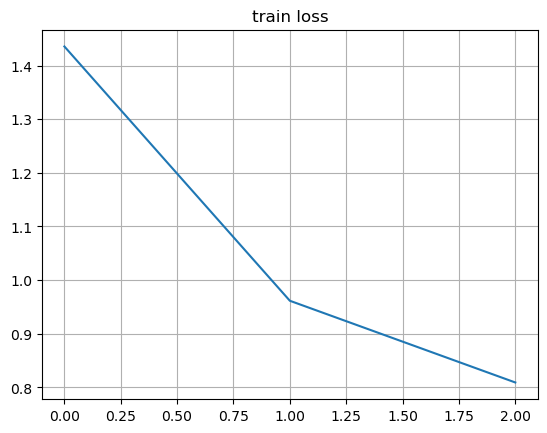

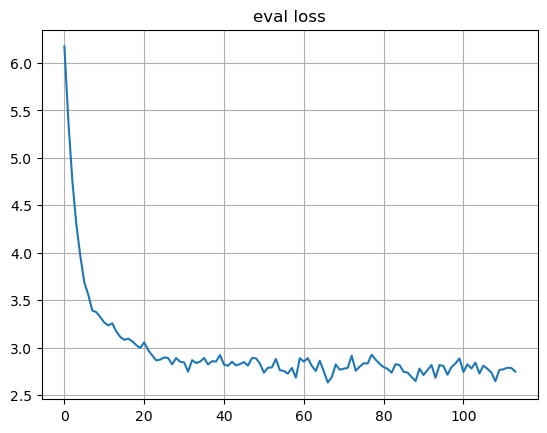

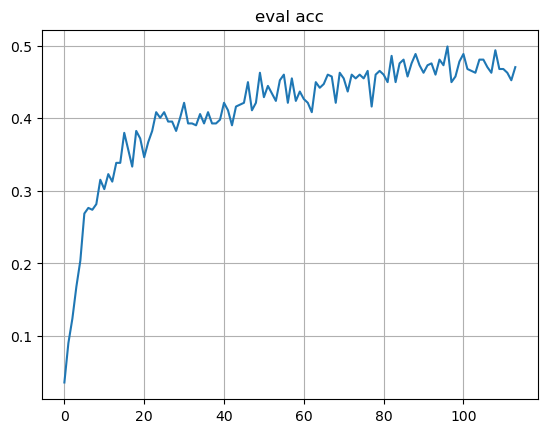

In [79]:


criterion = nn.CrossEntropyLoss()

losses, history = train_model(model=model,
                              optimizer=optimizer,
                              criterion=criterion,
                              train_dataloader=train_dl,
                              eval_dataloader=eval_dl,
                              num_epoch=3,
                              save_best=True, save_path='fc_do01_lr1e_3.pth')

eval_loss, eval_ac = eval_epoch(model, eval_dl, criterion)
print('-'*20)
print('final eval')
print('eval loss', float(eval_loss))
print('eval acc', float(eval_ac))

#########
#losses, history(val_loss, val_acc) per epo
eval_losses = [item[0] for item in history]
eval_acc = [float(item[1]) for item in history]

for name, data in zip(['train loss', 'eval loss', 'eval acc'], [losses, eval_losses, eval_acc]):
    plot_data(data, title=name)

# To submission

In [59]:
def prepare_csv(path):
    print('reading...')
    df = pd.read_csv(path)
    print('sorting...')
    df = df.sort_values(by=['SequenceId', 'T'], ascending=[True, True])
    print('daytiming...')
    df['T'] = pd.to_datetime(df['T'], unit='ms')

    # Создать отдельные колонки для года, месяца, дня месяца, дня недели и часа
    df['year'] = df['T'].dt.year
    df['month'] = df['T'].dt.month
    df['day'] = df['T'].dt.day
    df['day_of_week'] = df['T'].dt.dayofweek  # Понедельник = 0, Воскресенье = 6
    df['hour'] = df['T'].dt.hour
    #
    df = df.drop(['T', 'year'], axis=1)
    #
    print('encoding...')
    columns_to_encode = ['month', 'day', 'day_of_week', 'hour']
    df = pd.get_dummies(df, columns=columns_to_encode)
    #
    devices_ids = df['SequenceId'].unique()
    #
    target_column = 'SequenceId'
    print('to records...')
    records = {}

    '''for id in devices_ids:
        filtered_df = df[df['SequenceId'] == id]
        records[id] = filtered_df.drop(target_column, axis=1)'''
    #print(df.head())
    chunk_size = 300
    for i in range(0, len(df), chunk_size):
        device_recs = df.iloc[i:i+chunk_size].drop(target_column, axis=1)
        device_id = df['SequenceId'].iloc[i]
        #torch.tensor(records[device_id].to_numpy(), dtype=torch.float32)
        records[device_id] = torch.tensor(device_recs.to_numpy(), dtype=torch.float32)
        
    print('done')
    return records

    

In [60]:
pr_res = prepare_csv('test.csv')

norm2id = {}
for d_id, ind in id2norm.items():
    norm2id[ind] = d_id
print(norm2id)

reading...
sorting...
daytiming...
encoding...
to records...
done
{0: 7, 1: 8, 2: 9, 3: 12, 4: 23, 5: 25, 6: 26, 7: 27, 8: 33, 9: 37, 10: 39, 11: 45, 12: 47, 13: 51, 14: 52, 15: 57, 16: 58, 17: 65, 18: 67, 19: 68, 20: 70, 21: 71, 22: 73, 23: 74, 24: 75, 25: 78, 26: 79, 27: 81, 28: 87, 29: 89, 30: 90, 31: 91, 32: 92, 33: 94, 34: 95, 35: 96, 36: 99, 37: 104, 38: 105, 39: 108, 40: 110, 41: 111, 42: 116, 43: 117, 44: 120, 45: 122, 46: 124, 47: 126, 48: 127, 49: 129, 50: 134, 51: 137, 52: 142, 53: 145, 54: 148, 55: 149, 56: 152, 57: 156, 58: 157, 59: 158, 60: 159, 61: 162, 62: 163, 63: 168, 64: 169, 65: 174, 66: 175, 67: 177, 68: 183, 69: 187, 70: 188, 71: 189, 72: 190, 73: 194, 74: 196, 75: 204, 76: 206, 77: 207, 78: 211, 79: 213, 80: 216, 81: 219, 82: 222, 83: 224, 84: 229, 85: 232, 86: 233, 87: 234, 88: 236, 89: 237, 90: 239, 91: 240, 92: 261, 93: 263, 94: 268, 95: 269, 96: 270, 97: 271, 98: 273, 99: 274, 100: 275, 101: 277, 102: 281, 103: 282, 104: 283, 105: 284, 106: 285, 107: 289, 108

In [84]:
model = model.to(DEVICE)

In [87]:
def get_submissioncsv_depr(model, path):
    target_source = {}
    q_df = pd.read_csv('questions.csv')
    print(len(pr_res))
    print(len(q_df))
    return 
    for target_device_id in tqdm(pr_res.keys()):
        input = pr_res[target_device_id].to(DEVICE)
        outputs = model(input.unsqueeze(dim=0))#[0]

        preds = F.softmax(outputs, dim=0)
        target_prob = preds[id2norm[target_device_id]]
        print(target_prob)
        break
        pred = torch.argmax(outputs, 0)
        
        source_device_id = norm2id[int(pred)]
        target_source[target_device_id] = source_device_id
        #print(f'pred: {pred}, target_d_id: {target_device_id}, source_d_id: {source_device_id}')
        #print(target_source)
    q_df = pd.read_csv('questions.csv')
    questions = q_df.to_numpy()
    #
    submission_list = []
    for i, target_id, q_id in questions:
        #print(f'i{i}, targ_id: {target_id}, q_id: {q_id}, ts_dict: {target_source[target_id]}')
        local_answ = (target_source[target_id] == q_id)
        submission_list.append((i, int(local_answ)))
    #
    df = pd.DataFrame(submission_list, columns=['QuestionId', 'IsTrue'])

    df.to_csv(path, index=False)


In [61]:
def get_submissioncsv(model, path):
    target_source = {}
    submission_list = []
    
    q_df = pd.read_csv('questions.csv')
    questions = q_df.to_numpy()

    for i, target_id, q_id in tqdm(questions):
        with torch.no_grad():
            input = pr_res[target_id].to(DEVICE)
            outputs = model(input.unsqueeze(dim=0))[0]

            preds = F.softmax(outputs, dim=0)
            target_prob = preds[id2norm[q_id]]

        submission_list.append((i, float(target_prob)))
        
        #print(f'tar_prob: {target_prob}, q_id: {q_id}')
        

    #
    df = pd.DataFrame(submission_list, columns=['QuestionId', 'IsTrue'])

    df.to_csv(path, index=False)

In [74]:
get_submissioncsv(model=model,
                  path='trans69.csv')

  0%|          | 0/90024 [00:00<?, ?it/s]

100%|██████████| 90024/90024 [11:46<00:00, 127.40it/s]


# Summarize

  
<html>
 <head>
  <meta charset="utf-8">
 </head>
 <body>
  <table border="1">
   <tr>
    <th>Model type</th>
    <th>epohs</th>
    <th>best eval res</th>
    <th>total params</th>
    <th>final auc-roc score</th>
   </tr>
   <tr>
    <td>LSTM</td>
    <td>40</td>
    <td>70</td>
    <td>504195</td>
    <td>~0.59</td>
  </tr>

  <tr>
    <td>Conv Model</td>
    <td>5</td>
    <td>~55</td>
    <td>50792195</td>
    <td>-</td>
  </tr>

  <tr>
    <td>Transformer</td>
    <td>3-4</td>
    <td>~70</td>
    <td>2989951</td>
    <td>0.79314</td>
  </tr>

  <tr>
    <td>FC model</td>
    <td>3</td>
    <td>~49</td>
    <td>25780611</td>
    <td>-</td>
  </tr>
  
 </table>
 </body>
</html>

